# ANN - Lab 1c: Multi-layer perceptrons

Tudor Berariu

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib notebook
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

## The same dataset as before

In [2]:
def two_rings(N, separation=0.1, noise=0.1):
    N1 = N // 2
    N2 = N - N1
    angles = np.random.rand(N, 1) * 2 * np.pi
    radius = np.random.rand(N, 1) + np.random.randn(N, 1) * noise
    radius *= .5 - separation / 2
    radius[N2:] += .5 + separation / 2
    X = np.concatenate([radius * np.sin(angles), radius * np.cos(angles)], axis=1)
    T = np.concatenate([np.zeros((N1)), np.ones((N2))], axis=0)
    p = np.random.permutation(N)
    return X[p], T[p]

In [3]:
def visualize_dataset(X, T, Y=None):
    m = ["x", "o"]  # Indicates true class
    col = ["red", "blue"]  # Indicates prediction
    fig = plt.figure(); plt.axis('equal')
    if Y is not None:
        idx_tp = np.logical_and(T >= .5, Y >= .5) # True positives
        idx_fp = np.logical_and(T < .5, Y >= .5) # False positives
        idx_fn = np.logical_and(T >= .5, Y < .5) # False negatives
        idx_tn = np.logical_and(T < .5, Y < .5) # True negatives
        
        plt.scatter(X[idx_tp,0], X[idx_tp,1], marker=m[0], c="red", label="TP")
        plt.scatter(X[idx_fp,0], X[idx_fp,1], marker=m[1], c="red", label="FP")
        plt.scatter(X[idx_fn,0], X[idx_fn,1], marker=m[0], c="blue", label="FN")
        plt.scatter(X[idx_tn,0], X[idx_tn,1], marker=m[1], c="blue", label="TN")

    else:
        idx_pos, idx_neg = (T > .5), (T < .5)
        plt.scatter(X[idx_pos,0], X[idx_pos,1], marker=m[0], color="blue", label="Pos")
        plt.scatter(X[idx_neg,0], X[idx_neg,1], marker=m[1], color="blue", label="Neg")
    
    plt.xlabel("x"); plt.ylabel("y")
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    return fig.axes[0]

In [4]:
def split_dataset(X, T, train=.8):
    N = X.size(0)
    N_train = int(round(N * train))
    N_test = N - N_train

    X_train, X_test = X[:N_train,:], X[N_train:,:]
    T_train, T_test = T[:N_train], T[N_train:]
    return X_train, T_train, X_test, T_test

In [5]:
def plot_evolution(train_acc, test_acc, train_nll, test_nll):
    epochs_no = len(train_acc)
    fig, (ax1, ax2) = plt.subplots(2,1);
    ax1.plot(range(epochs_no), train_acc, sns.xkcd_rgb["green"], label="Train Accuracy")
    ax1.plot(range(epochs_no), test_acc, sns.xkcd_rgb["red"], label="Test Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='lower right', ncol=1)

    ax2.plot(range(epochs_no), train_nll, sns.xkcd_rgb["green"], label="Train NLL")
    ax2.plot(range(epochs_no), test_nll, sns.xkcd_rgb["red"], label="Test NLL")
    ax2.set_xlabel("iteration")
    ax2.set_ylabel("NLL")
    ax2.legend(loc='upper right', ncol=1);
    return (ax1, ax2)

### Creating a neural network

In [6]:
linear1 = nn.Linear(2, 5)
linear2 = nn.Linear(5, 2)
model = nn.Sequential(linear1, nn.Sigmoid(), linear2)
model

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=5, out_features=2, bias=True)
)

In [7]:
X, T = two_rings(1000, separation=.0, noise=.1)

X = torch.from_numpy(X).clone().float()
T = torch.from_numpy(T).clone().long()

X_train, T_train, X_test, T_test = split_dataset(X, T, train=.05)

<IPython.core.display.Javascript object>


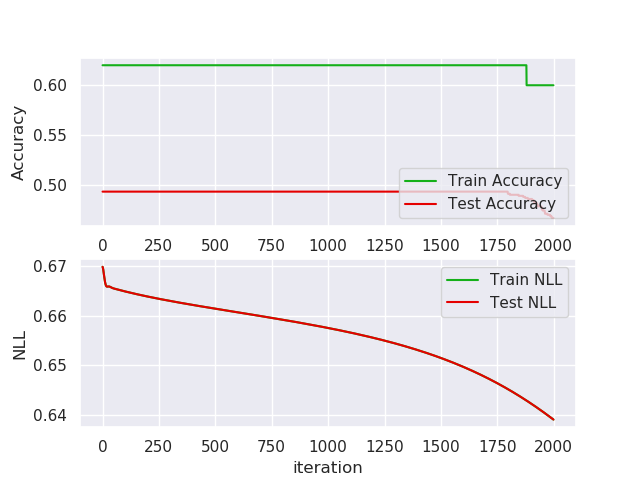

In [8]:
EPOCHS_NO = 2000

optimizer = optim.SGD(model.parameters(), lr=.01, momentum=0.9)
losses = []

train_acc, test_acc, train_nll, test_nll = [], [], [], []

for _ in range(EPOCHS_NO):
    optimizer.zero_grad()
    
    Y_train = model(X_train)
    loss = F.cross_entropy(Y_train, T_train)
    
    loss.backward()
    optimizer.step()
    
    model.eval()
    Y_test = model(X_test)
    eval_loss = F.cross_entropy(Y_train, T_train)
    model.train()
    _, ind = Y_train.max(dim=1)
    train_acc.append((ind == T_train).sum().item() / Y_train.size(0))
    _, ind = Y_test.max(dim=1)
    test_acc.append((ind == T_test).sum().item() / Y_test.size(0))
    train_nll.append(loss.item())
    test_nll.append(eval_loss.item())
    
    
plot_evolution(train_acc, test_acc, train_nll, test_nll);

<IPython.core.display.Javascript object>


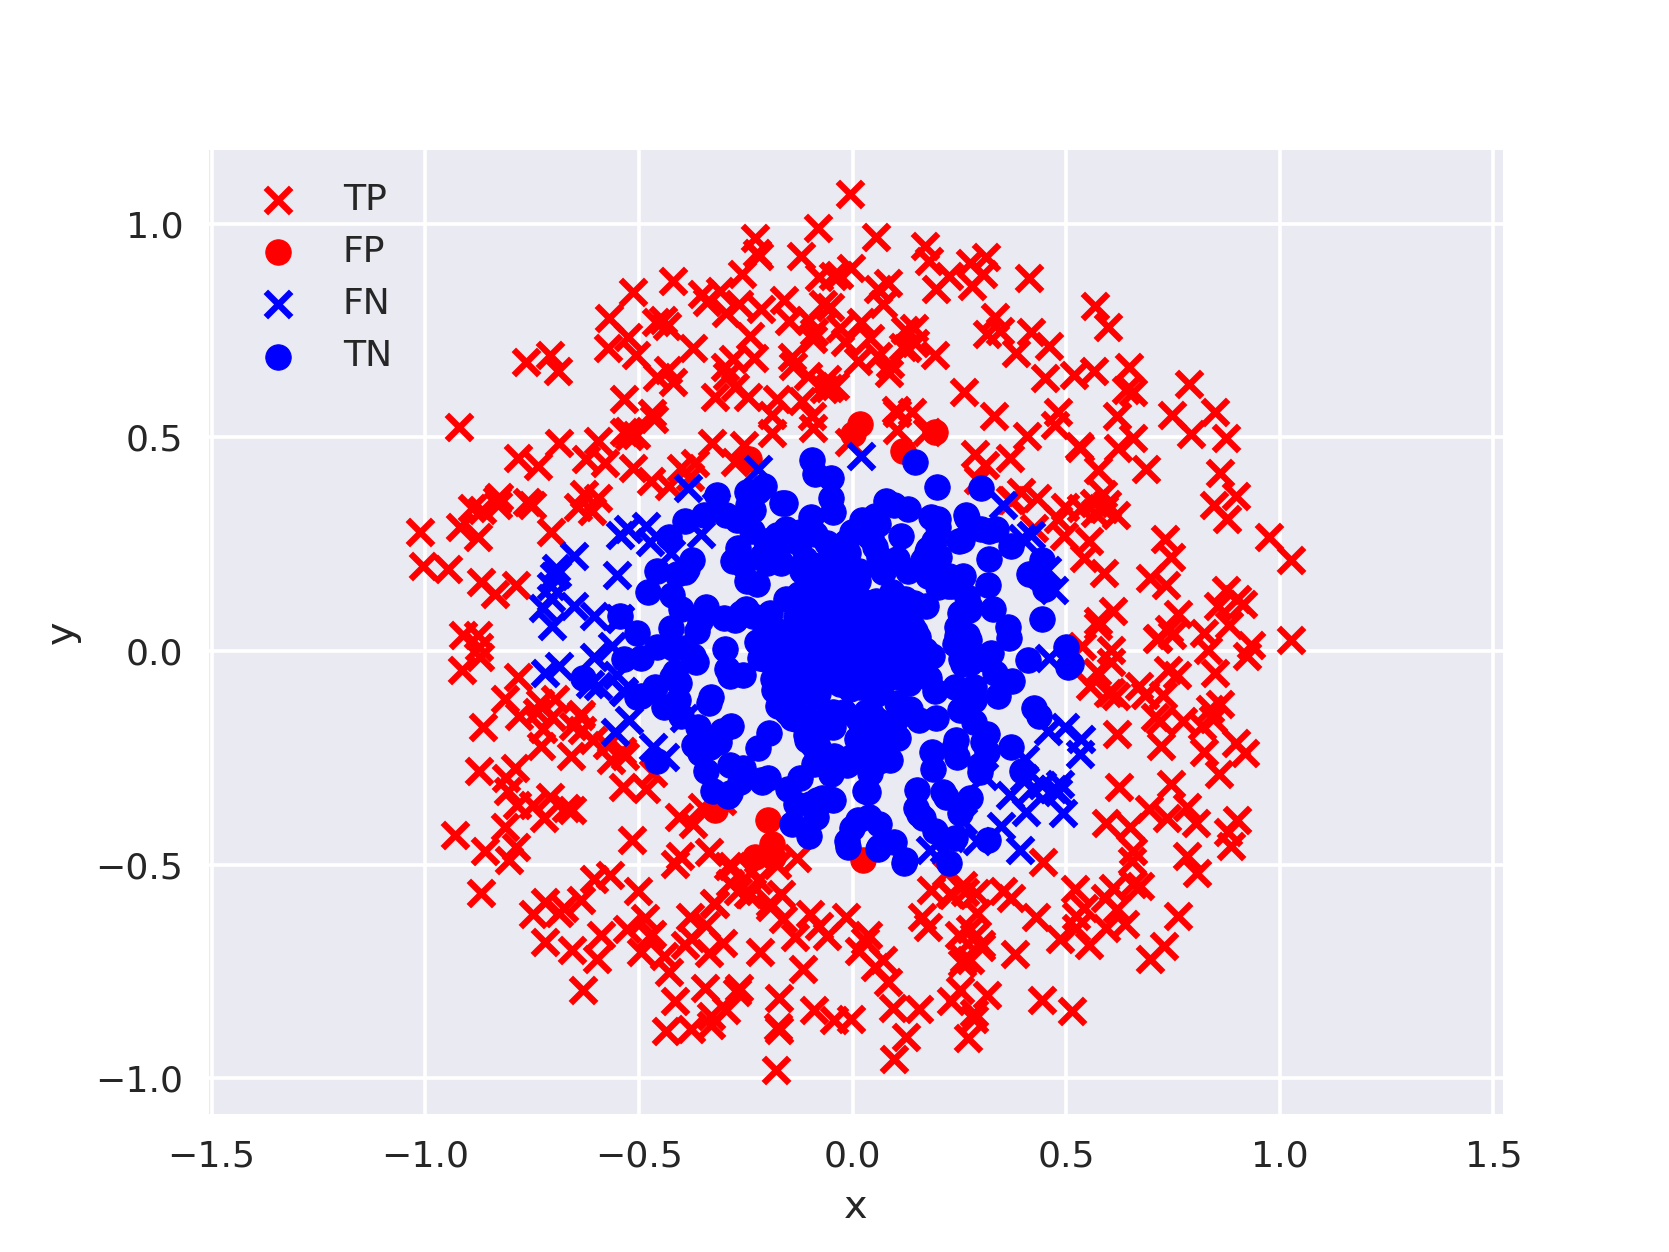

<IPython.core.display.Javascript object>


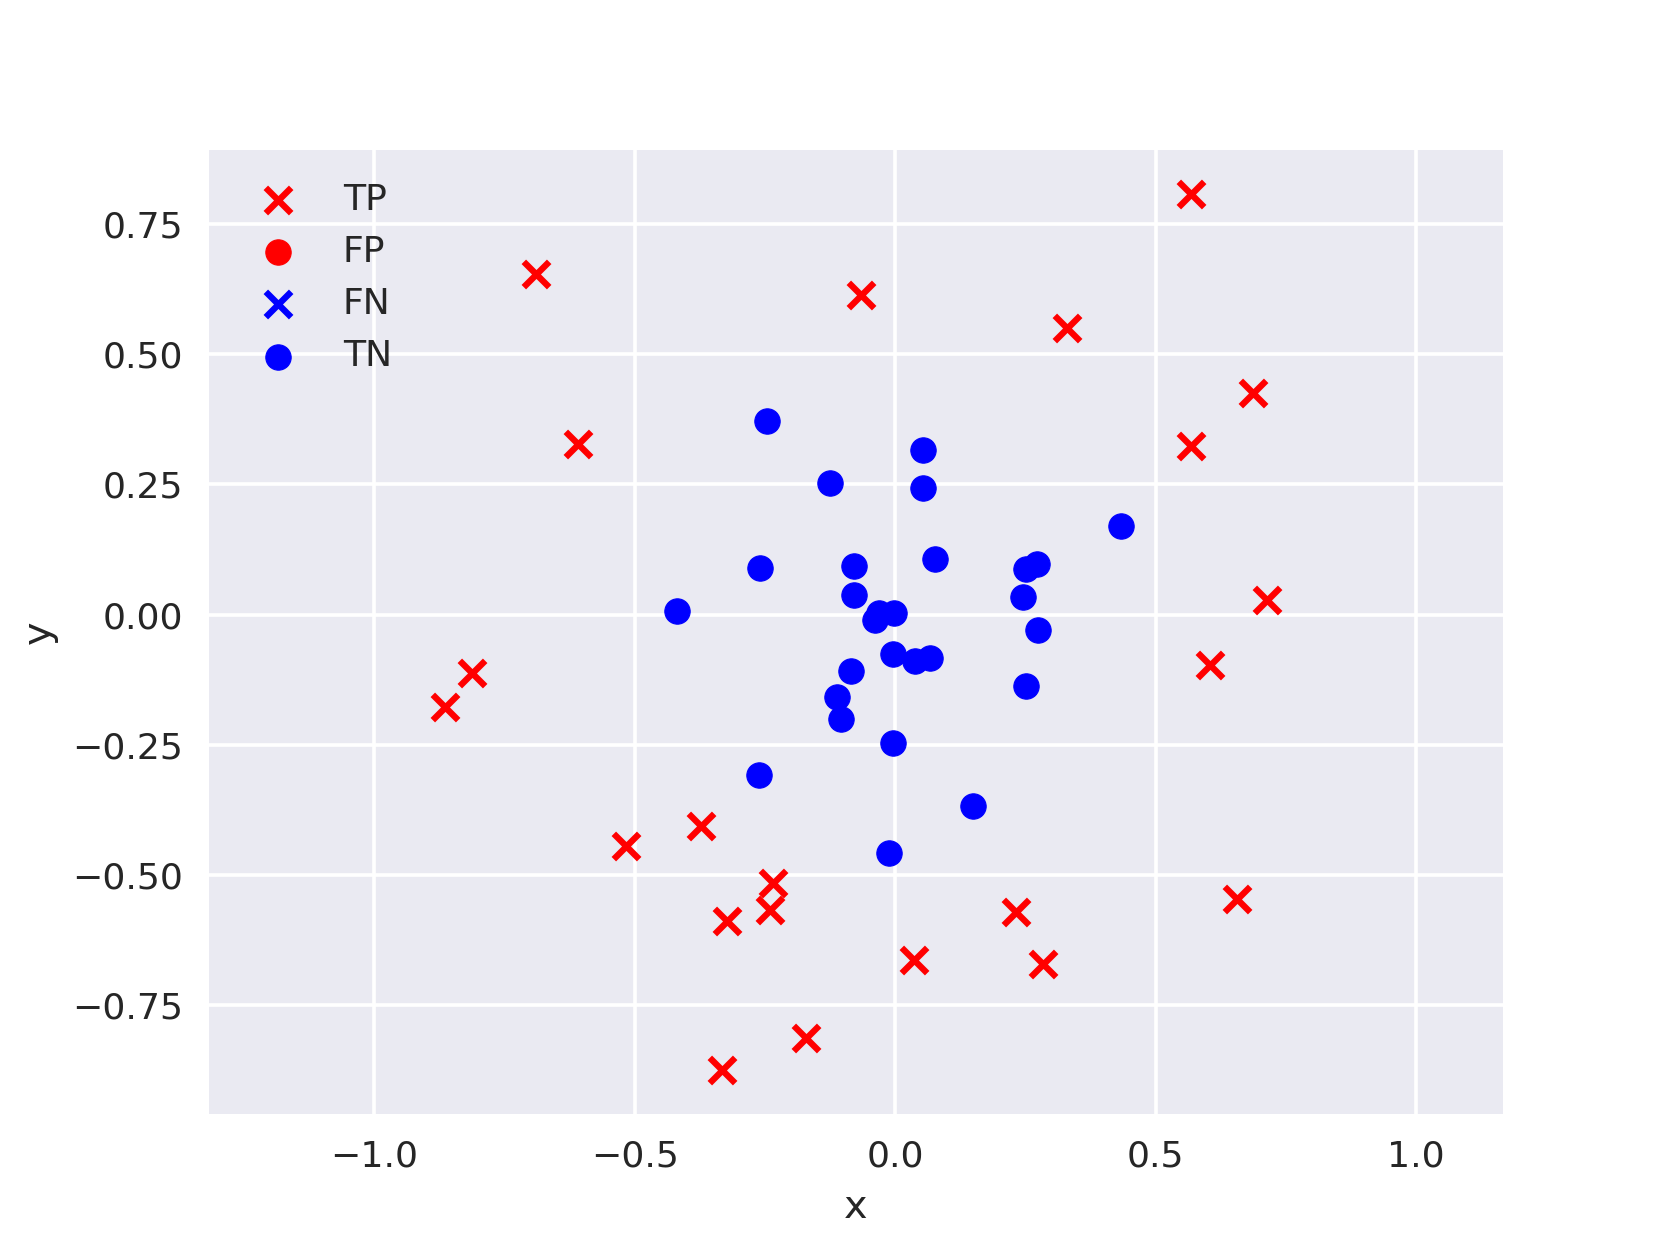

In [44]:
_, Y = model(X).max(dim=1)
_, Y_train = model(X_train).max(dim=1)
visualize_dataset(X.numpy(), T.numpy(), Y=Y.numpy());
visualize_dataset(X_train.numpy(), T_train.numpy(), Y=Y_train.numpy());

In [41]:
linear1.weight, linear1.bias

(Parameter containing:
 tensor([[ 5.4470,  0.0507],
         [ 4.0838,  7.8171],
         [ 0.3372,  0.3528],
         [-2.0702,  5.7660],
         [-1.8247,  0.3292]]), Parameter containing:
 tensor([-2.2158,  3.8366,  0.3141, -2.4646,  0.9164]))

<IPython.core.display.Javascript object>


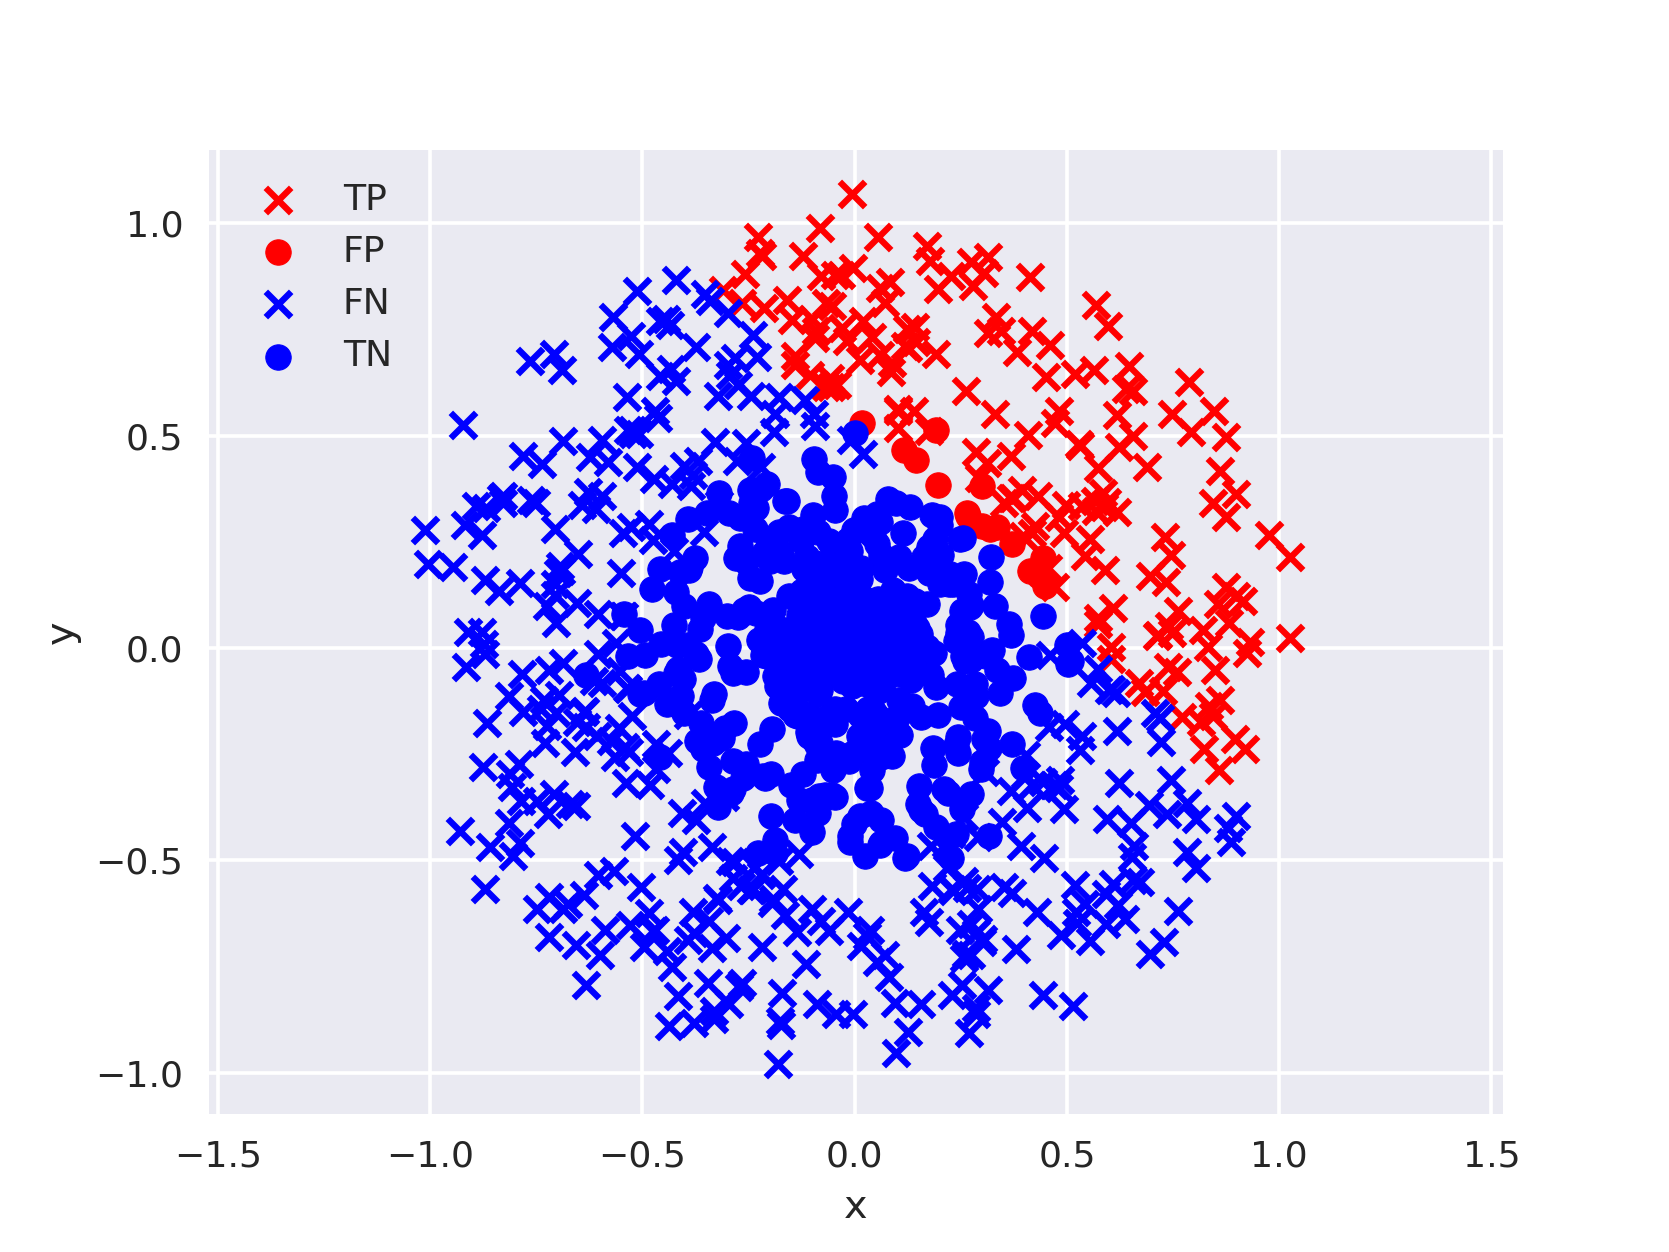

In [67]:
IDX = 2

y = X @ linear1.weight[IDX] + linear1.bias[IDX]
visualize_dataset(X.numpy(), T.numpy(), Y=(y.detach().numpy()));

<IPython.core.display.Javascript object>


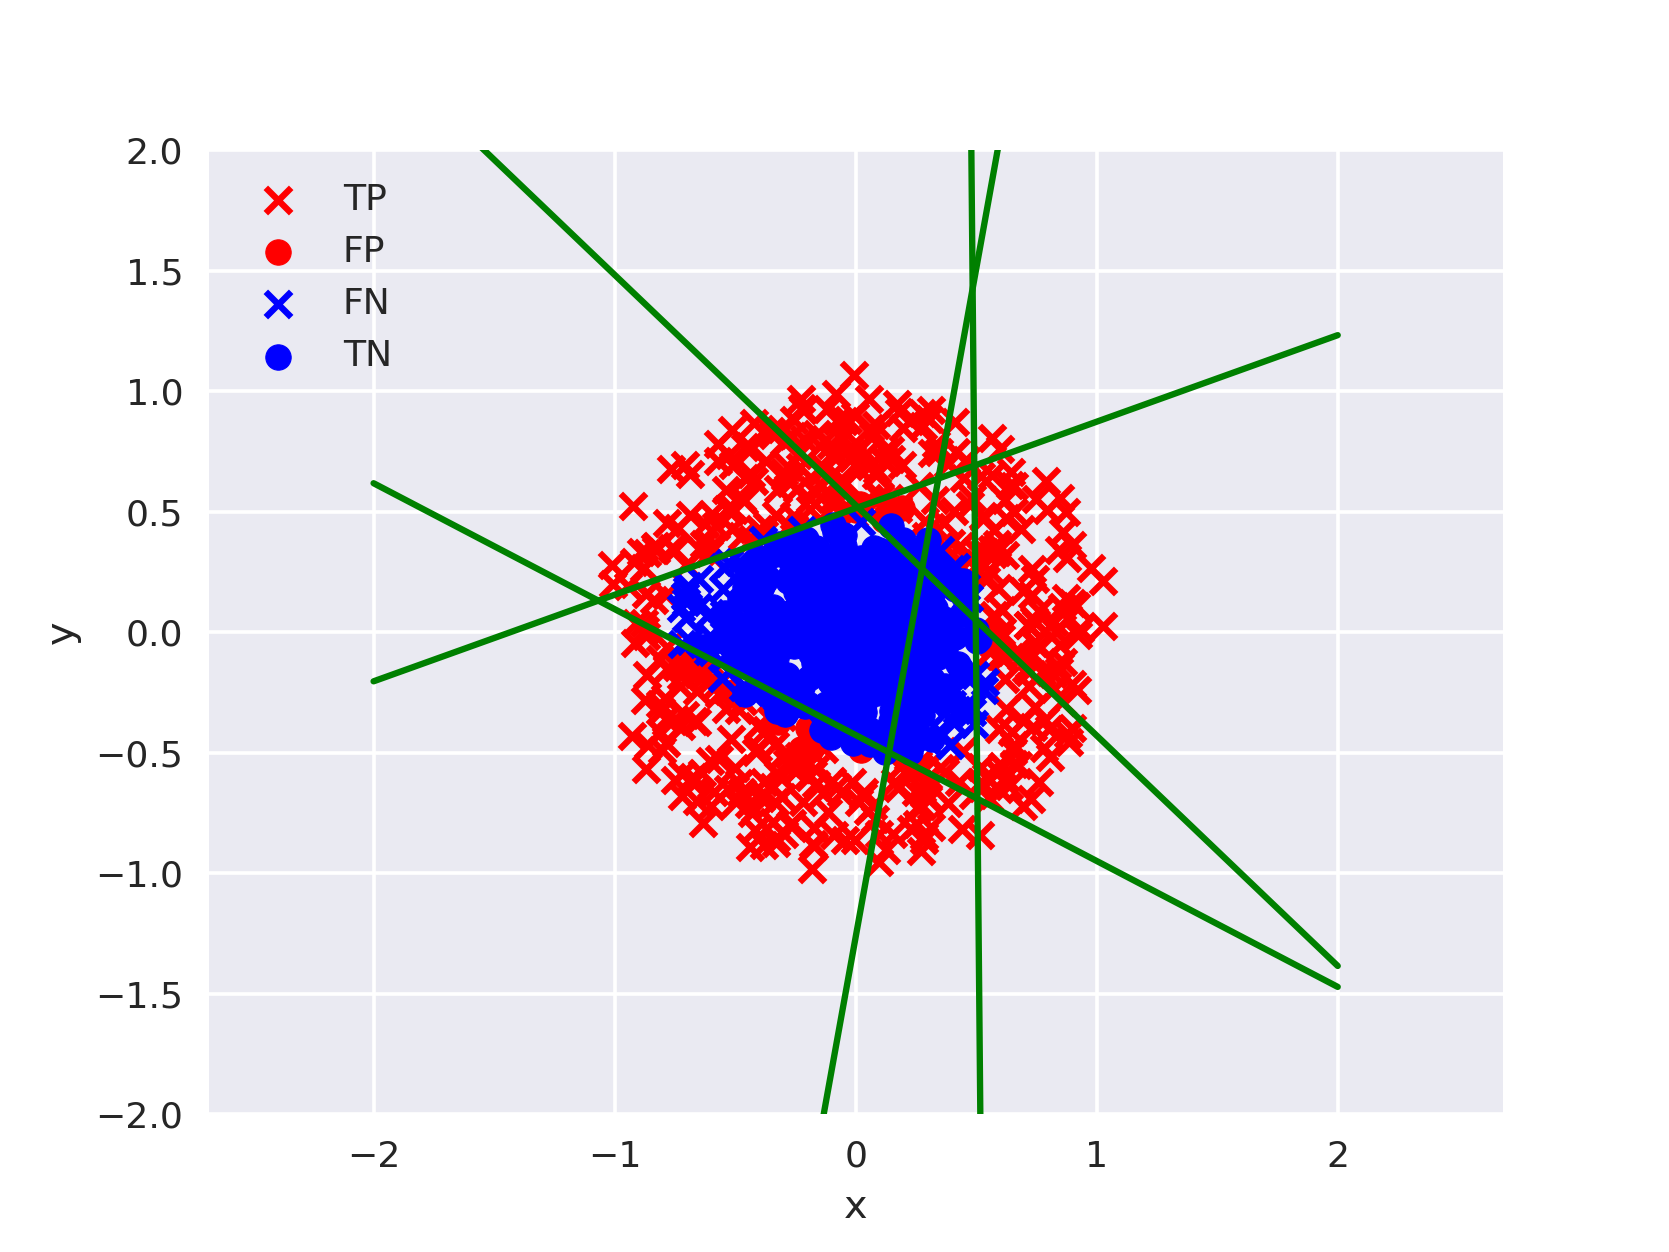

In [56]:
ax = visualize_dataset(X.numpy(), T.numpy(), Y=Y.numpy());
plt.ylim(-2, 2)
for i in range(linear1.weight.size(0)):
    w = linear1.weight[i].tolist()
    b = linear1.bias[i].item()
    __x = np.linspace(-2, 2, 100)
    __y = (.5 - __x * w[0] - b) / w[1]
    plt.plot(__x, __y, c="green", axes=ax)
plt.show()